# EEG Deep Learning Pipeline (GCN, ROC, PR, t-SNE)

Plug in your own `de_features` and `labels` numpy arrays!
Graph Convolutional Network (GCN)
ROC, PR, Confusion Matrix, Loss Curve, t-SNE
Clean code, modular functions, ready to extend.

In [ ]:
!pip install mne

In [ ]:
!pip install torch-geometric scikit-learn matplotlib seaborn


In [ ]:
# --- Install (if running in Colab) ---

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, roc_curve, auc,
                             precision_recall_curve, average_precision_score)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

# For reproducibility
torch.manual_seed(42)
np.random.seed(42)


In [ ]:
# 2. Graph construction (customize for your band features/adjacency if needed)
from sklearn.preprocessing import StandardScaler
def create_graph_from_eeg(features, threshold=0.5):
    arr = features.flatten().reshape(-1, 1)  # Ensure shape (channels, 1)
    arr = StandardScaler().fit_transform(arr)
    corr_matrix = np.corrcoef(arr.T) if arr.shape[1] > 1 else np.eye(arr.shape[0])
    corr_matrix[corr_matrix < threshold] = 0
    edge_index = np.nonzero(corr_matrix)
    edge_index = torch.tensor(edge_index, dtype=torch.long)
    x = torch.tensor(arr, dtype=torch.float32)
    return Data(x=x, edge_index=edge_index)


In [ ]:
# 3. Dataset Class: Automatically constructs a graph for each sample.
class EEGGraphDataset(torch.utils.data.Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
    def __len__(self):
        return len(self.features)
    def __getitem__(self, idx):
        data = create_graph_from_eeg(self.features[idx])
        data.y = torch.tensor(self.labels[idx], dtype=torch.long)
        return data


In [ ]:
# 4. Train/val/test split
X_train, X_test, y_train, y_test = train_test_split(all_features, labels, test_size=0.2, stratify=labels, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)
train_dataset = EEGGraphDataset(X_train, y_train)
val_dataset   = EEGGraphDataset(X_val, y_val)
test_dataset  = EEGGraphDataset(X_test, y_test)
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE)


In [ ]:
# 5. Model definition (with Dropout, BatchNorm)
class RestHGCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=0.3):
        super(RestHGCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
    def forward(self, x, edge_index, batch):
        x = F.relu(self.bn1(self.conv1(x, edge_index)))
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        x = global_mean_pool(x, batch)
        return x


In [ ]:
def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data.x, data.edge_index, data.batch)  # <--- fix here!
        loss = criterion(output, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def eval_epoch(model, loader, device):
    model.eval()
    y_true, y_logits, y_probs = [], [], []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            logits = model(data.x, data.edge_index, data.batch)  # <--- fix here!
            probs = torch.softmax(logits, dim=1)
            y_true.extend(data.y.cpu().numpy())
            y_logits.extend(logits.cpu().numpy())
            y_probs.extend(probs.cpu().numpy())
    return np.array(y_true), np.array(y_logits), np.array(y_probs)


In [ ]:
# 7. Training loop (with early stopping, scheduler)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
INPUT_DIM = 1  # adjust if you have multi-band features
HIDDEN_DIM = 64
OUTPUT_DIM = 2
DROPOUT = 0.3
model = RestHGCN(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM, DROPOUT).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
patience = 10
best_val_loss = float('inf')
best_state = None
epochs_no_improve = 0
train_loss_hist, val_loss_hist = [], []
for epoch in range(1, 101):
    train_loss = train_epoch(model, train_loader, optimizer, criterion, DEVICE)
    y_val, y_val_logits, y_val_prob = eval_epoch(model, val_loader, DEVICE)
    val_loss = criterion(torch.tensor(y_val_logits, dtype=torch.float, device=DEVICE),torch.tensor(y_val, dtype=torch.long, device=DEVICE)).item()

    train_loss_hist.append(train_loss)
    val_loss_hist.append(val_loss)
    scheduler.step(val_loss)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_state = model.state_dict()
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
    print(f"Epoch {epoch:03d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    if epochs_no_improve > patience:
        print('Early stopping!')
        break
# Load best model
if best_state is not None:
    model.load_state_dict(best_state)


Epoch 001 | Train Loss: 0.7242 | Val Loss: 0.6990
Epoch 002 | Train Loss: 0.6536 | Val Loss: 0.6987
Epoch 003 | Train Loss: 0.6289 | Val Loss: 0.6998
Epoch 004 | Train Loss: 0.7537 | Val Loss: 0.7009
Epoch 005 | Train Loss: 0.6349 | Val Loss: 0.7019
Epoch 006 | Train Loss: 0.6280 | Val Loss: 0.7035
Epoch 007 | Train Loss: 0.8324 | Val Loss: 0.7048
Epoch 008 | Train Loss: 0.7333 | Val Loss: 0.7049
Epoch 009 | Train Loss: 0.7365 | Val Loss: 0.7053
Epoch 010 | Train Loss: 0.7018 | Val Loss: 0.7057
Epoch 011 | Train Loss: 0.6814 | Val Loss: 0.7061
Epoch 012 | Train Loss: 0.7041 | Val Loss: 0.7066
Epoch 013 | Train Loss: 0.7257 | Val Loss: 0.7067
Early stopping!


Test Accuracy: 0.5
Test Precision: 0.0
Test Recall: 0.0
Test F1: 0.0


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


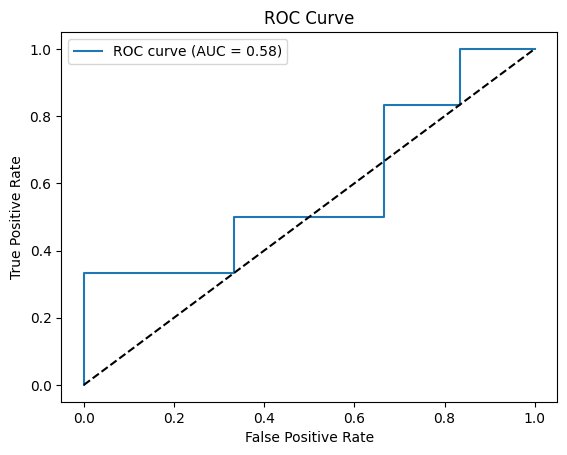

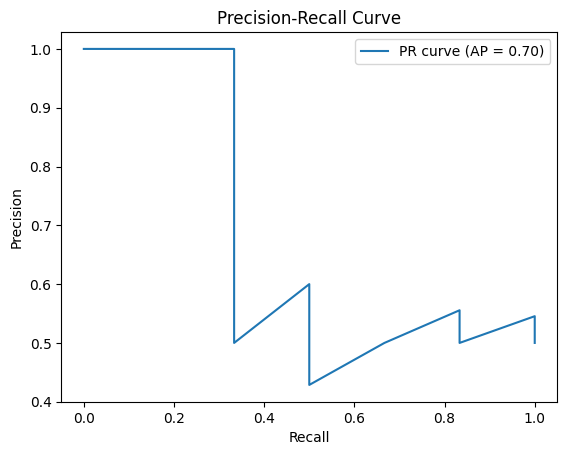

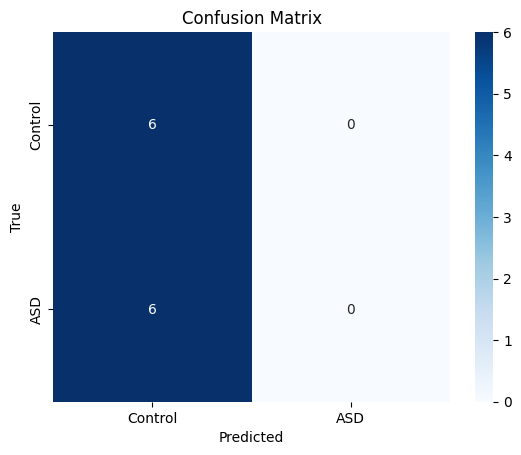

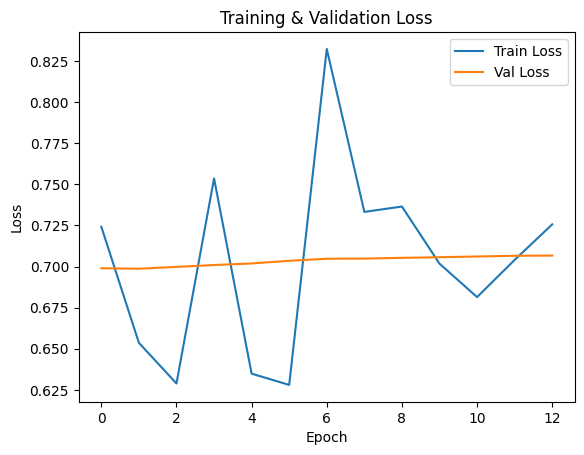

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, precision_recall_curve, average_precision_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

y_test, y_pred_logits, y_score = eval_epoch(model, test_loader, DEVICE)

# If y_pred_logits is logits, convert to predicted class
y_pred_classes = np.argmax(y_pred_logits, axis=1)
# For ROC and PR, use the score/probability for the positive class
y_score_pos = y_pred_logits[:, 1]  # or y_score[:, 1] if that's your probability output

print('Test Accuracy:', accuracy_score(y_test, y_pred_classes))
print('Test Precision:', precision_score(y_test, y_pred_classes))
print('Test Recall:', recall_score(y_test, y_pred_classes))
print('Test F1:', f1_score(y_test, y_pred_classes))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_score_pos)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_score_pos)
ap_score = average_precision_score(y_test, y_score_pos)
plt.figure()
plt.plot(recall, precision, label=f'PR curve (AP = {ap_score:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure()
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Control','ASD'], yticklabels=['Control','ASD'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Training/Validation Loss
plt.figure()
plt.plot(train_loss_hist, label='Train Loss')
plt.plot(val_loss_hist, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.show()


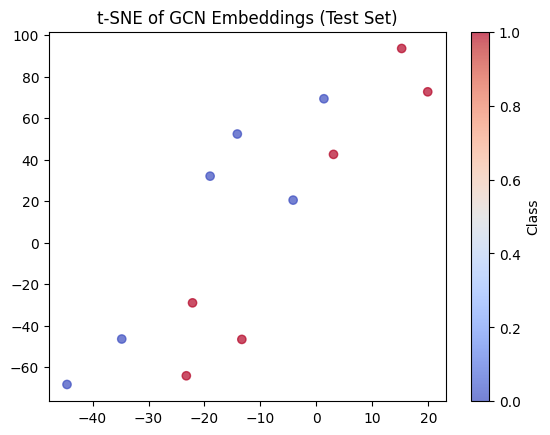

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

embeddings = []
tsne_labels = []
model.eval()
with torch.no_grad():
    for data in test_loader:
        data = data.to(DEVICE)
        x = F.relu(model.bn1(model.conv1(data.x, data.edge_index)))
        x = global_mean_pool(x, data.batch)
        embeddings.append(x.cpu().numpy())
        tsne_labels.extend(data.y.cpu().numpy())
embeddings = np.vstack(embeddings)

n_samples = embeddings.shape[0]
tsne = TSNE(n_components=2, random_state=42, perplexity=min(5, n_samples-1))
z = tsne.fit_transform(embeddings)

plt.figure()
plt.scatter(z[:,0], z[:,1], c=tsne_labels, cmap='coolwarm', alpha=0.7)
plt.title('t-SNE of GCN Embeddings (Test Set)')
plt.colorbar(label='Class')
plt.show()
